In [200]:
import pandas as pd
import numpy as np
from typing import Optional
from datetime import date
import math
import pickle
import matplotlib.pyplot as plt
from dataclasses import asdict, dataclass

In [199]:
df = pd.read_excel('1.ОСНОВНОЙ Факт объемы_м3_2017_2022_по дням1.xlsx', header=1, sheet_name=1)
df

,Unnamed: 0,МСК,СЗ,Урал,всего Хранение,всего Обработка,Unnamed: 6,МСК.1,СЗ.1,Урал.1,...,СЗ.4,Урал.4,всего Хранение,Unnamed: 24,Unnamed: 25,Unnamed: 26,МСК.5,СЗ.5,Урал.5,всего Обработка.1
0,2018-01-01,4690.500000,1647.911946,1611.92,7950.331946,0.000000,NaN,NaN,NaN,0.00,...,1100,1500,8600,NaN,NaN,Январь,6000.0,800.0,800.0,7600.0
1,2018-01-02,4690.500000,1647.911946,1611.92,7950.331946,0.000000,NaN,NaN,NaN,0.00,...,1100,1500,8600,NaN,NaN,Февраль,6000.0,800.0,800.0,7600.0
2,2018-01-03,4690.500000,1647.911946,1611.92,7950.331946,0.000000,NaN,NaN,NaN,0.00,...,1100,1500,8600,NaN,NaN,Март,6000.0,800.0,1500.0,8300.0
3,2018-01-04,4690.500000,1647.911946,1611.92,7950.331946,0.000000,NaN,NaN,NaN,0.00,...,1100,1500,8600,NaN,NaN,Апрель,6000.0,800.0,1500.0,8300.0
4,2018-01-05,4690.500000,1647.911946,1611.92,7950.331946,0.000000,NaN,NaN,NaN,0.00,...,1100,1500,8600,NaN,NaN,Май,7500.0,1200.0,1500.0,10200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2018-12-27,4592.037120,1569.538560,1943.27,8104.845680,107.346496,NaN,72.126496,9.68,25.54,...,2500,2500,11500,NaN,NaN,NaN,NaN,NaN,NaN,NaN
361,2018-12-28,4542.693852,1579.698560,1928.63,8051.022412,97.836934,NaN,46.716934,44.08,7.04,...,2500,2500,11500,NaN,NaN,NaN,NaN,NaN,NaN,NaN
362,2018-12-29,4502.393764,1549.158560,1932.45,7984.002324,8.447093,NaN,4.147093,0.41,3.89,...,2500,2500,11500,NaN,NaN,NaN,NaN,NaN,NaN,NaN
363,2018-12-30,4498.258807,1549.158560,1932.45,7979.867367,0.000000,NaN,0.000000,0.00,0.00,...,2500,2500,11500,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [193]:
@dataclass
class Row:
    date: date
    keeping_actual: float
    keeping_reserved: float
    processing_actual: float
    receiving_actual: float
    shipment_actual: float  
    processing_reserved: float
        
month_ru_to_num = {"январь": 1, "февраль": 2, "март": 3, "апрель": 4, "май": 5, "июнь": 6, "июль": 7, "август": 8, "сентябрь": 9, "октябрь": 10, "ноябрь": 11, "декабрь": 12}

In [198]:
def process_sheet(warehouse_name: str, month_column: str, date_column: str):
    processing_reserved_month = {}
    results = []
    for idx, row in df.iterrows():
        if idx == 12:
            break

        month = month_ru_to_num[row[month_column].lower()]
        try:
            processing_reserved_month[month] = row[f'{warehouse_name}.5']
        except KeyError:
            processing_reserved_month[month] = row['МСК.1']

    def fillna(num: float):
        return num if not pd.isnull(num) else 0
    for idx, row in df.iterrows():
        cur_date = row[date_column]
        try:
            row_ = Row(date=cur_date, 
                       keeping_actual=fillna(row[warehouse_name]), 
                       processing_actual=fillna(row[f'{warehouse_name}.1']),
                       receiving_actual=fillna(row[f'{warehouse_name}.2']),
                       shipment_actual=fillna(row[f'{warehouse_name}.3']),
                       keeping_reserved=fillna(row[f'{warehouse_name}.4']), 
                       processing_reserved=processing_reserved_month[cur_date.month])
        except KeyError:
            row_ = Row(date=cur_date, 
                       keeping_actual=fillna(row[warehouse_name]), 
                       processing_actual=fillna(row[f'{warehouse_name}.1']),
                       receiving_actual=fillna(row[f'{warehouse_name}.2']),
                       shipment_actual=fillna(row[f'{warehouse_name}.3']),
                       keeping_reserved=fillna(row['МСК']), 
                       processing_reserved=processing_reserved_month[cur_date.month])
        results.append(row_)
    return results

warehouses = {"МСК": [], "СЗ": [], "Урал": [], "МСК 101": [], "МСК 107": [], "МСК Демонтаж": []}    
## SHEET 1
df = pd.read_excel('1.ОСНОВНОЙ Факт объемы_м3_2017_2022_по дням1.xlsx', header=1, sheet_name=1)
for key, value in warehouses.items():
    if key in ['МСК', 'СЗ', 'Урал']:
        value.extend(process_sheet(key, 'Unnamed: 26', 'Unnamed: 0'))

### SHEET 2
df = pd.read_excel('1.ОСНОВНОЙ Факт объемы_м3_2017_2022_по дням1.xlsx', header=1, sheet_name=2)
for key, value in warehouses.items():
    if key in ['МСК', 'СЗ', 'Урал']:
        value.extend(process_sheet(key, 'Unnamed: 24', 'склад'))

### SHEET 3
df = pd.read_excel('1.ОСНОВНОЙ Факт объемы_м3_2017_2022_по дням1.xlsx', header=1, sheet_name=3, skipfooter=14)
for key, value in warehouses.items():
    if key in ['МСК', 'СЗ', 'Урал']:
        value.extend(process_sheet(key, 'Unnamed: 25', 'Unnamed: 0'))
        
## SHEET 4
df = pd.read_excel('1.ОСНОВНОЙ Факт объемы_м3_2017_2022_по дням1.xlsx', header=1, sheet_name=4)
df = df.drop(df.index[59])
df = df.drop(df.index[365:])
for key, value in warehouses.items():
    if key in ['МСК 101', 'МСК 107', 'СЗ', 'МСК Демонтаж', 'Урал']:
        value.extend(process_sheet(key, 'Unnamed: 33', 'дата'))
    

dfs = {key: (pd.DataFrame((asdict(row) for row in warehouse)).fillna(0.0)) for key, warehouse in warehouses.items()}
dfs
with open('dfs.pkl', 'wb') as f:
    pickle.dump(dfs, f)
    
dfs

{'МСК':            date  keeping_actual  keeping_reserved  processing_actual  \
 0    2018-01-01         4690.50              6000               0.00   
 1    2018-01-02         4690.50              6000               0.00   
 2    2018-01-03         4690.50              6000               0.00   
 3    2018-01-04         4690.50              6000               0.00   
 4    2018-01-05         4690.50              6000               0.00   
 ...         ...             ...               ...                ...   
 1091 2020-12-27        10366.74             10800             216.05   
 1092 2020-12-28        10503.06             10800             276.93   
 1093 2020-12-29        10543.22             10800             423.23   
 1094 2020-12-30        10448.22             10800             276.70   
 1095 2020-12-31        10421.97             10800             386.44   
 
       receiving_actual  shipment_actual  processing_reserved  
 0                 0.00             0.00           

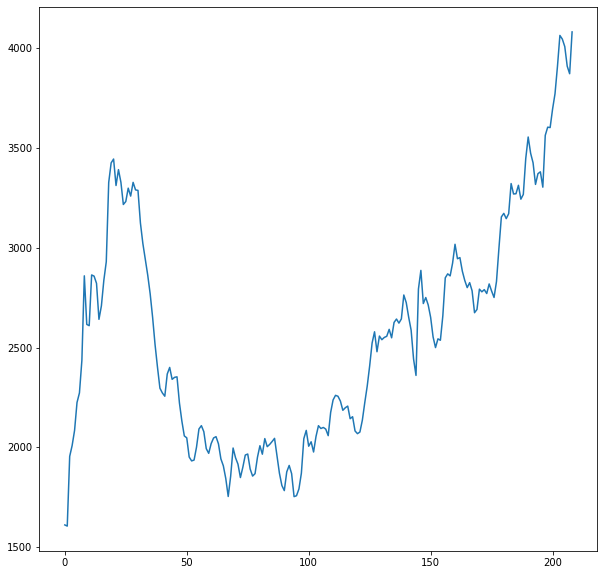

In [251]:
plt.figure(figsize=(10, 10))
ural = dfs['Урал']
ural_grouped_1 = ural.groupby(pd.PeriodIndex(ural['date'], freq="W"))['keeping_actual'].mean()
# ural_grouped_2 = ural.groupby(pd.PeriodIndex(ural['date'], freq="M"))['processing_actual'].mean()
plt.plot(ural_grouped_1.to_list())
# plt.plot(ural_grouped_2.to_list())
# plt.plot(ural['date'], ural['receiving_actual'])
# plt.plot(ural['date'], ural['shipment_actual'])
# plt.plot(ural['date'], ural['processing_actual'])
# plt.plot(ural['date'], ural['processing_reserved'])